## Introduction

In this tutorial, you will learn to use the Keras library with the Tensorflow backend. Deep learning is a trending application of statistics which has been used to great success in areas such as computer vision and natural language processing. The Keras library is a framework for building and training deep learning models. Due to its ease of use and intuitive syntax, it has quickly become the one of the most popular deep learning framework among deep learning researchers.

## Installation

Before we can play with Keras, we first need to install the Tensorflow backend. You can install Tensorflow using pip. Note that the latest version of Tensorflow requires Python3!

    $ pip3 install --upgrade tensorflow
    
Once Tensorflow has been installed, try running the following cell to ensure that everything works properly

In [1]:
import warnings
warnings.filterwarnings('ignore')  # Tensorflow throws a lot of warnings about possible optimizations in instruction sets
import tensorflow as tf

hello = tf.constant('Hello world!')
sess = tf.Session()
print(sess.run(hello))

b'Hello world!'


Now that we've installed Tensorflow, we can install Keras. You can install Keras using pip:

    $ pip install keras
    
Once the installation has completed, make sure that all the following commands work:

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, MaxPooling2D, Input, Flatten

Using TensorFlow backend.


### GPU Support

Although the examples in this tutorial will be computationally light, deep learning is notorious for requiring a lot of computation and consequently a lot of time. As a result, it is usually recommended that you train your models using a GPU. This subsection will show you how to install Tensorflow with GPU support.

**Note that this only works with certain NVIDIA graphics cards! If your computer does not have a compatible NVIDIA graphics card, please skip this section.**

Tensorflow with GPU support requires two pieces of NVIDIA software: the CUDA Toolkit 9.0 and cuDNN v7. CUDA Toolkit 9.0 can be installed by visting [NVIDIA's CUDA downloads page](https://developer.nvidia.com/cuda-downloads). Select the proper installation for your system, then follow the on-screen instructions. cuDNN v7 can be downloaded from [NVIDIA's cuDNN download page](https://developer.nvidia.com/cudnn). Once it has been downloaded, make sure to add the cuDNN DLL directory to your \$PATH\$ variable.

Once you have installed the pre-requisite software, you can install Tensorflow with GPU support with pip:

    $ pip3 install --upgrade tensorflow-gpu
    
Rerun the following commands to make sure that everything works as expected:

In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, MaxPooling2D, Input, Flatten

## Example: Handwriting classification with MNIST data

It is often helpful to explore a problem while learning a library. In this tutorial, we will walk through classifying handwritten digits in the MNIST database.

### Loading MNIST data

Keras comes prepackaged with the MNIST dataset. We can import and load the data with just a few lines of code:

x_train shape: (60000, 28, 28), y_train shape: (60000,)
x_test shape: (10000, 28, 28), y_test shape: (10000,)
Example image with label: 5


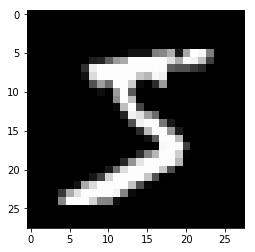

In [4]:
from keras.datasets import mnist


(x_train, y_train), (x_test, y_test) = mnist.load_data()
print('x_train shape: {}, y_train shape: {}'.format(x_train.shape, y_train.shape))
print('x_test shape: {}, y_test shape: {}'.format(x_test.shape, y_test.shape))
print('Example image with label: {}'.format(y_train[0]))
plt.imshow(x_train[0], cmap='gray')

As we can see, each sample comes in the form of a 28x28 black and white image, where each pixel is represented as a single value ranging from 0 to 255. The sample has a corresponding label ranging from 0 to 9 which denotes which digit it is.

Since the label is a categorical variable, we would prefer to represent it using a dummy vector. Keras has a utility function which automatically converts categorical variables to a one-hot vector representation:

In [5]:
num_classes = 10  # we are classifying from 0 to 9

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
print(y_train[0])

[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


### Background: Neural Networks

This section will provide a brief overview of the models we will be building and the syntax for defining these models in Keras.

To classify the digits in the MNIST dataset, we will be training a **convolutional neural network**, which is a special type of neural network. A **neural network** is composed of small units called **neurons**. Each neuron can be represented as a function, with its own parameters. For example, one type of neuron could be represented as $f(x; w) = w\cdot x$, where $x, w$ are both vectors. In this case, the neuron's parameters are represented by the vector $w$, and it applies a linear transformation to the input vector $x$. 

These neurons are usually grouped into **layers**, which can be applied to larger inputs to transform it into a different output. A neural network can then be composed of several layers, each performing a transformation on some input then passing the result to another layer.

To train a neural network, we must pass samples through the network. Once the network tells us its prediction, we compare it to the true label using a **loss function** - essentially a measure of how off the network is. Based on whether or not the network's label was correct, the network will change the weights of all its neurons in a process called **backpropagation** in order to minimize the loss.

Luckily for us, Keras handles almost all of these implementation details. The only thing we need to do is specify the general architecture of our network. We will be training a convolutional neural network based on the architecture described by Yann LeCun in 1989. This network, known as LeNet, involves the following layers stacked on top of each other:

1. Convolution layer
2. ReLU activation layer
3. Max pooling layer
4. Convolution layer
5. ReLU activation layer
6. Max pooling layer
7. Fully connected layer
8. ReLU activation layer
9. Fully connected layer
10. Softmax activation layer

Let's take a closer look how these layers work. 

#### Convolution layer

The convolution layer, as you might infer from the name, is the main workhorse of the convolutional neural network. This layer is composed of several **filters**, which slide over the input data and perform a convolution operation.

In the following code, you can see a basic implementation of the convolution operation. As you will see, the filter is like a small "window" through which the image is transformed. Depending on the weights in the filter, the resulting image changes dramatically.

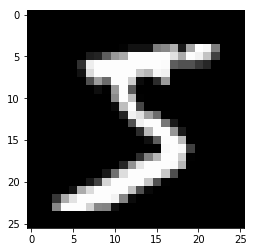

In [6]:
def convolution(filt, img):
    filtw, filth = filt.shape
    marginw = (filtw // 2)
    marginh = (filth // 2)
    imgw, imgh = img.shape
    
    new_img = np.zeros((imgw - marginw * 2, imgh - marginh * 2))
    
    # Slide filter over entire image to generate new image
    for i in range(new_img.shape[0]):
        for j in range(new_img.shape[1]):
            window = img[i: i + filtw, j: j + filth]
            new_img[i, j] = np.sum(window * filt)
            
    return new_img

identity_filter = np.array([[0, 0, 0],
                            [0, 1, 0],
                            [0, 0, 0]]) 

plt.imshow(convolution(identity_filter, x_train[0]), cmap='gray')

In this first example, we show a filter which assigns full weight to the center pixel and none to those on the sides. As a result, nothing changes in the resulting image.

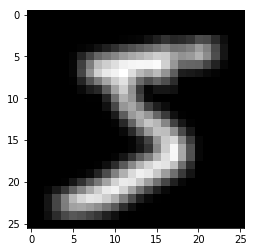

In [7]:
blur_filter = np.array([[.11, .11, .11],
                        [.11, .11, .11],
                        [.11, .11, .11]])

plt.imshow(convolution(blur_filter, x_train[0]), cmap='gray')

In this second example, we show a filter which assigns the same weight to all the pixels in the filter. The resulting pixel is the average of everything that surrounded the original pixel. As a result, we end up with an image where all the pixels are blurred together.

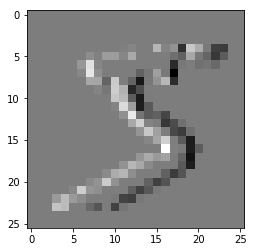

In [8]:
edge = np.array([[0, 0, 0],
                        [-1, 1, 0],
                        [0, 0, 0]])

plt.imshow(convolution(edge, x_train[0]), cmap='gray')

In this example, the filter has a value of -1 and a value of 1 in two adjacent pixels, and 0 everywhere else. Therefore, it only returns a positive value if there are two very different values adjacent to each other in the original image - in other words, an edge.

Over the course of the training process, the filter learns better weights until it is able to pick out useful features. Since the filter is applied over the entire image, it is invariant to translation - no matter where the feature is in the original image, the filter will detect it. All of these features make the convolution layer extremely useful for image classification tasks.

You can easily define a convolution layer in Keras with the Conv2D() class:

In [9]:
conv_layer = Conv2D(32, kernel_size=(3, 3), input_shape=(28, 28), activation='relu')

Let's unpack the arguments to the Conv2D initalizer. The first argument defines the number of filters that make up the layer. The next argument, "kernel_size", defines the dimensions of each filter. The third argument defines the size of the input. The final argument describes the activation function, which is explained in the next section.

#### Rectified linear activation

After each convolution layer, we add a rectified linear (ReLU) activation layer. This layer takes each output of the previous layer and perform the following function: $f(x) = max(0, x)$. Essentially, if an output from the previous layer was negative, it is set to 0 instead. 

The intuition behind this operation is that it adds a source of nonlinearity into the network. Notice that the convolution operation is essentially still linear, since it is similar to a weighted sum. Therefore, the network as a whole would have difficulty representing non-linear relationships between input and output without a non-linear operation such as ReLU. As seen above, any layer in Keras can have an additional ReLU activation layer added by specifying "activation='relu'".

#### Max pooling layer

A max pooling layer simply takes the maximum of the inputs within a certain window. The intuition is that a small offset of a pixel or two does not significantly change an image. By applying max pooling, we will find the important activations of the previous layer even if it is slightly offset. We can define a max pooling layer using similar syntax:

In [10]:
pool_layer = MaxPooling2D(pool_size=(2, 2))

Here, the "pool_size" determines the size of the window in which the layer performs the max operation. Notice that since the max pooling layer must come after another layer, there is no need to specify the input size - Keras will automatically figure it out based on the output dimensions of the layer before it.

#### Fully connected layer with softmax activation

Finally, we have the fully connected layer. Of all the layers this one is the most simple. It is essentially a layer composed of the "linear" neurons we described earlier. The softmax activation basically normalizes the results of the previous layer by making the output values all add to one. Creating a fully connected layer is just like the other layers:

In [11]:
fc_layer = Dense(10, activation='softmax')

Here, the first argument specifies the dimension of the output. Just as before, the "activation" argument tells us what function to apply in the activation layer that comes after the fully connected layer.

### Model initialization

At this point, we know how to create new layers. But how do we put them together into a complete model? The first method is to use Keras' Sequential API. We can simply define:

In [12]:
model = Sequential()

Then we can just add the layers we want one after another using the "add()" function in the Sequential API:

In [13]:
rows = 28
cols = 28
input_shape=(rows, cols, 1)

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())  # This layer purely reshapes the data and does not otherwise transform it
model.add(Dense(128, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

#### Functional API vs Sequential API

Note that the Sequential API, as its name suggests, only allows you to create a model where each layer feeds its output to the next in a sequence. For more complicated models, Keras also offers a Functional API. In the functional API, each layer can be thought of as a function. Applying a layer $f$ to another layer $g$ in this way is akin to saying that the output of $g$ should be fed as input into $f$. As an example, our same model declared above could also be declared functionally like this:

In [14]:
mnist_img = Input(shape=input_shape)  # A special layer that accepts inputs in the functional API
x = Conv2D(32, kernel_size=(3, 3), activation='relu')(mnist_img)  # Notice that we are applying Conv2D as a function!
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(32, kernel_size=(3, 3), activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dense(num_classes, activation='softmax')(x)

func_model = Model(input=mnist_img, output=x)

For this example task, we do not need anything more than the Sequential API. However, if you want to create complicated models with multiple inputs/outputs or shared layers, you can make use of the Functional API.

#### Compilation

After declaring the model, we can compile it with the following command:

In [15]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

Here, we can specify the loss function we want to minimize and the optimizer that we want to use, as well as any metrics we want to track. We use categorical crossentropy as the loss function - it is essentially a generalization of binary crossentropy. We also use the Adam optimizer - this optimizer is similar to stochastic gradient descent with momentum. Finally, we want to keep track of our model accuracy.

In [16]:
x_train = x_train.astype(float)
x_train /= 255
x_test = x_test.astype(float)
x_test /= 255
x_train = x_train.reshape(x_train.shape[0], rows, cols, 1)
x_test = x_test.reshape(x_test.shape[0], rows, cols, 1)

As a last touch, we normalize our input features and reshape our data to fit Keras' expected input shape (Keras expects an additional dimension to represent the color channel). We can finally train our model by calling the "fit()" function. Here we provide our training data, validation data, the batch size (which controls how many samples are used at a time) and the epoch limit (the number of times the model trains across the whole dataset before terminating).

In [17]:
batch_size = 64
epochs = 8
hist = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=0,
          validation_data=(x_test, y_test))

The "fit()" returns a History object which contains all the metrics across the training episode. We can examine how the loss and accuracy differed across epochs. 

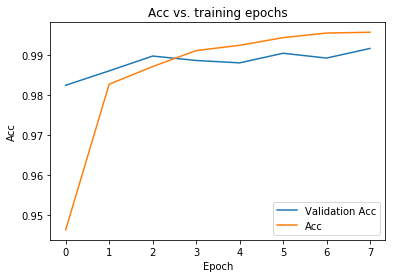

In [18]:
plt.plot(range(epochs), hist.history['val_acc'], hist.history['acc'])
plt.title('Acc vs. training epochs')
plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.legend(['Validation Acc', 'Acc'])
plt.show()

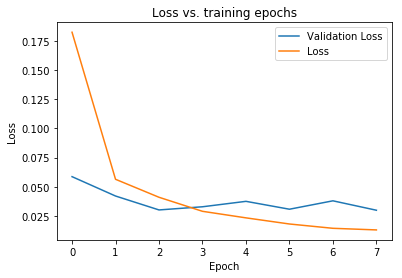

In [19]:
plt.plot(range(epochs), hist.history['val_loss'], hist.history['loss'])
plt.title('Loss vs. training epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Validation Loss', 'Loss'])
plt.show()

As we can see, LeNet is exceptionally effective at solving the handwriting classification problem, achieving 98% accuracy on the validation data after only a single epoch!

## References and further reading

Further information on the topics in this tutorial can be found at the following sources:
1. [Convolutional Networks](http://cs231n.github.io/convolutional-networks/)
1. [Handwritten Digit Recognition with a Back-Propagation Network](http://yann.lecun.com/exdb/publis/pdf/lecun-90c.pdf)
2. [Keras Documentation](https://keras.io/)
3. [MNIST Database of handwritten digits](http://yann.lecun.com/exdb/mnist/)